# LIBRARIES

In [1]:
import pickle
from Environment import *
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from step3_ucb1 import *
from step4_ucb1 import *
from step5_ucb1 import *
from Step3_TS import *
from Step4_TS import *

# ENVIRONMENT DEFINITION 

- Environment fixed informations and Products definition

In [2]:
np.random.seed(1)

products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]
# Dictionary fixing the secondary products linked to 
secondary_dict= {        
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}

# Matrix n_prod*n_prices collecting the possible prices for each product. Prices are in ascending order
prices = [[8., 9, 10, 11],
          [10., 11, 12, 13],
          [20., 21, 23, 25],
          [28., 30, 31, 33],
          [40., 42, 43, 45]]
# Production cost of the products
cost = [5, 7.8, 18.1, 23.5, 32]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente
# Computation of margins linked to each product for a particular choice of price
cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2
# Creation of the 5 objects of Product class
for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# Parameter for the computation of the click probability on the SECOND secondary product
lambda_q = 0.7

- User Category 1: Young and Inexpert

In [3]:
# Parameters for the distribution describing the reservation price
res_price_params_1 = {
    "mean": [9, 15, 22, 33, 35],
    "std": [1, 2, 1, 1.5, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_1 = [[0, 0.7, 0.3, 0, 0],
                 [0.6, 0, 0.5, 0, 0],
                 [0, 0.7, 0, 0.3, 0],
                 [0, 0, 0.4, 0, 0.1],
                 [0.5, 0, 0.3, 0, 0]]
prob_lambda_1 = lambda_correct(np.matrix(probabilities_1), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_1 = [15, 15, 10, 5, 5]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_1 = [2, 1, .5, .2, .1]

user1 = UserCat(alphas_1, res_price_params_1, poisson_lambda_1, prob_lambda_1)

- User Category 2: Old and Inexpert

In [4]:
# Parameters for the distribution describing the reservation price
res_price_params_2 = {
    "mean": [9, 16, 25, 41, 47],
    "std": [1, 2.5, 1.5, 3, 2]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_2 = [[0, 0.5, 0.4, 0, 0],
                 [0.4, 0, 0.6, 0, 0],
                 [0, 0.7, 0, 0.5, 0],
                 [0, 0, 0.5, 0, 0.3],
                 [0, 0, 0.5, 0.3, 0]]
prob_lambda_2 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_2 = [7, 12, 12, 12, 7]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_2 = [0.5, 1, 2, 1, 0.5]

user2 = UserCat(alphas_2, res_price_params_2, poisson_lambda_2, prob_lambda_2)

- User Category 3: Expert

In [5]:
# Parameters for the distribution describing the reservation price
res_price_params_3 = {
    "mean": [8, 13, 24, 39, 50],
    "std": [1, 1.5, 2, 2, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_3 = [[0, 0, 0.6, 0.4, 0],
                 [0, 0, 0, 0.7, 0.4],
                 [0, 0.4, 0, 0.6, 0],
                 [0, 0, 0.3, 0, 0.7],
                 [0, 0, 0.4, 0.6, 0]]
prob_lambda_3 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_3 = [5, 5, 10, 15, 15]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_3 = [0.1, 0.2, 0.5, 1.5, 1.5]

user3 = UserCat(alphas_3, res_price_params_3, poisson_lambda_3, prob_lambda_3)

- User Category 0: Aggregated demand

In [6]:
# Parameters for the distribution describing the reservation price
res_price_params_0 = {
    "mean": [9.7, 12.7, 24.5, 31.6, 41.1],
    "std": [1.5, 2, 4, 2.5, 3]
}

# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_0 = [[0, 0.6, 0.2, 0, 0],
                 [0.5, 0, 0.4, 0, 0],
                 [0, 0.5, 0, 0.5, 0],
                 [0, 0, 0.6, 0, 0.5],
                 [0, 0, 0.3, 0.5, 0]]
prob_lambda_0 = lambda_correct(np.matrix(probabilities_0), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_0 = [10, 10, 10, 10, 10]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_0 = [1.5, 1, .5, .5, .2]

user0 = UserCat(alphas_0, res_price_params_0, poisson_lambda_0, prob_lambda_0)

- Environment creation

In [7]:
# list of users 
#users = [user1, user2, user3]
users = [user0]
# probability distribution of the users
#p_users = [1/3, 1/3, 1/3]
p_users = [1]

env = Environment(users, products, secondary_dict, p_users)

In [8]:
env.optimal_reward()

(10.325578532573228, [0, 1, 2, 1, 0])

In [9]:
env.expected_reward([2,3,2,1,0])

8.769613519581187

In [10]:
np.matrix(env.theoretical_values['conversion_rates'][0])

matrix([[0.87146285, 0.67963081, 0.42074029, 0.19306234],
        [0.91149201, 0.80233746, 0.63683065, 0.44038231],
        [0.86970548, 0.80921305, 0.64616977, 0.45026178],
        [0.9250663 , 0.7389137 , 0.59483487, 0.28773972],
        [0.64306616, 0.38208858, 0.263258  , 0.09680048]])

In [11]:
np.random.seed(0)
a = env.simulate_day(200, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold"])
a

{'CR_data': array([[66., 88., 84., 50., 21.],
        [77., 96., 97., 50., 40.]]),
 'initial_prod': array([45., 42., 57., 27., 30.]),
 'n_prod_sold': array([[167., 166., 115.,  76.,  27.],
        [ 66.,  88.,  84.,  50.,  21.]]),
 'CR_vector': array([0.85714285, 0.91666666, 0.86597937, 0.99999998, 0.52499999]),
 'alpha_ratios': array([0.2238806 , 0.20895522, 0.28358209, 0.13432836, 0.14925373]),
 'mean_prod_sold': array([2.53030299, 1.88636361, 1.3690476 , 1.51999997, 1.28571422])}

In [12]:
np.random.seed(0)
a = env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"], aggregated= False)
a

{'CR_data': array([[ 734.,  877.,  869.,  508.,  262.],
        [ 853.,  975., 1005.,  542.,  434.]]),
 'initial_prod': array([567., 366., 553., 224., 294.]),
 'n_prod_sold': array([[1780., 1714., 1271.,  765.,  325.],
        [ 734.,  877.,  869.,  508.,  262.]]),
 'graph_weights': array([[0.        , 0.57231405, 0.15523466, 0.        , 0.        ],
        [0.46428571, 0.        , 0.28494624, 0.        , 0.        ],
        [0.        , 0.48467153, 0.        , 0.3579235 , 0.        ],
        [0.        , 0.        , 0.61044176, 0.        , 0.31390134],
        [0.        , 0.        , 0.28205128, 0.33532934, 0.        ]]),
 'visualizations': array([[  0., 484., 554.,   0.,   0.],
        [616.,   0., 558.,   0.,   0.],
        [  0., 685.,   0., 732.,   0.],
        [  0.,   0., 249.,   0., 446.],
        [  0.,   0., 195., 167.,   0.]]),
 'clicks': array([[  0., 277.,  86.,   0.,   0.],
        [286.,   0., 159.,   0.,   0.],
        [  0., 332.,   0., 262.,   0.],
        [  0., 

- Reservation Price Distribution Plot for one user

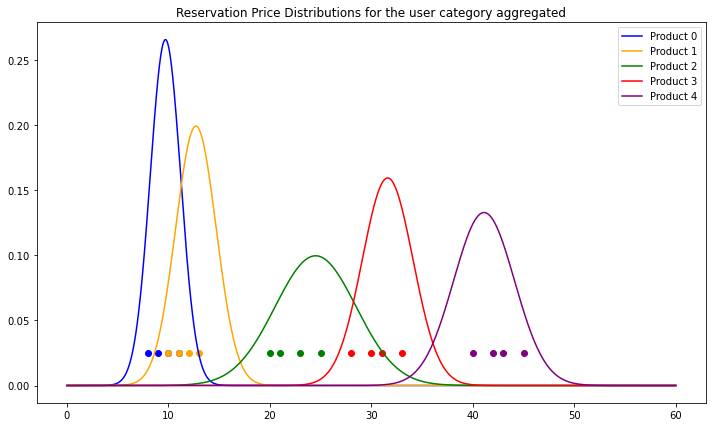

In [13]:
user_index = 0
x = np.arange(0, 60 , .01)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    res_price_distr = env.users[user_index].res_price_distr[i]
    y = res_price_distr.pdf(x)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])

for i in range(5):
    for j in range(4):
        plt.scatter(prices[i][j], 0.025, color = color_list[i])

plt.title("Reservation Price Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

# Greedy Algorithm Example

In [14]:
greedy_optimizer = Greedy_optimizer(env)
greedy_optimizer.run()

{'expected_reward': 10.325578532573228, 'combination': [0, 1, 2, 1, 0]}

In [15]:
env.optimal_reward()

(10.325578532573228, [0, 1, 2, 1, 0])

# STEP 3 : Uncertain Convertion Rates

## - TS

In [10]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = Step3_TS(env, initial_beta, learning_rate = 0.5)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner.reward_history = []
learner.price_comb_history = []
learner.cr_matrix_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner.run(n_days, daily_users)

# collect all informations for the plot
opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

In [ ]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

### Explore the istant regret in the collected runs of the step 3 learner

In [ ]:
opt_reward = learner.opt_reward
(opt_reward - collected_rewards)[-2][-20:]

In [ ]:
learner.price_comb_history[-1][-20:]

- ### Comparison between mean conversion rates estimated by last run of TS and real values

In [ ]:
CR_mean = np.array(learner.cr_matrix_list).mean(axis = 0)
i = 9
CR_i = learner.cr_matrix_list[i]
print("Mean of estimated conversion rates \n", CR_mean)

print("\nEstimated conversion rates for run %d \n" %i, CR_i)

In [ ]:
np.matrix(env.theoretical_values['conversion_rates'][0])

In [ ]:
# CODICE PER TESTARE SE UN PREZZO PER UN DETERMINATO PRODOTTO E' STATO "ESPLORATO" DALL'ALGORITMO
comb_list = learner.price_comb_history[-1]
count = 0
prod = 0
price = 0

for comb in comb_list :
    count += 1 if comb[prod] == price else 0

count

## - UCB1

In [28]:
# setting the run parameters
n_runs = 5
daily_users = 200
n_days = 300

In [31]:
step3_ucb1_R = []
step3_ucb1_collected_rewards = []
opt_reward = env.optimal_reward()[0]
for _ in range(n_runs):
    ucb3 = step3_ucb1(daily_users, len(prices), len(prices[0]), prices, env)
    instant_regret = []
    step3_ucb1_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb3.pull_arms()
        day_data = env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])
        cr_data = day_data["CR_data"]
        ucb3.update(pulled_arms, cr_data)
        reward = env.expected_reward(pulled_arms)
        step3_ucb1_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    step3_ucb1_collected_rewards.append(step3_ucb1_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    step3_ucb1_R.append(cumulative_regret)

In [33]:
# store the result
with open("step3_ucb1_R", 'wb') as f1:
    pickle.dump(step3_ucb1_R, f1)
with open("step3_ucb1_collected_rewards", 'wb') as f1:
    pickle.dump(step3_ucb1_collected_rewards, f1)

In [34]:
# load the result
with open("step3_ucb1_R", 'rb') as f1:
    step3_ucb1_R = pickle.load(f1)
with open("step3_ucb1_collected_rewards", 'rb') as f1:
    step3_ucb1_collected_rewards = pickle.load(f1)

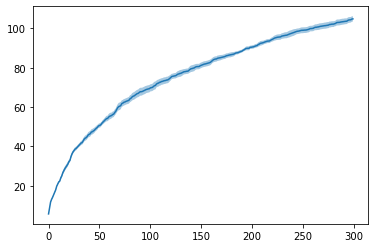

In [35]:
# plot of the result
mean_step3_ucb1_R = np.mean(step3_ucb1_R, axis=0)
std_dev_step3_ucb1 = np.std(step3_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step3_ucb1_R)
plt.fill_between(range(n_days), mean_step3_ucb1_R-std_dev_step3_ucb1, mean_step3_ucb1_R+std_dev_step3_ucb1, alpha=0.4)

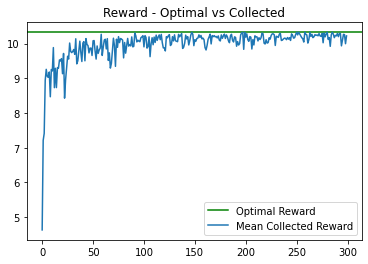

In [36]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step3_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [37]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb3.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

Last n pulled arms:


[[0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0],
 [0, 1, 2, 0, 0]]

In [39]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb3.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

C:\Users\stefa\AppData\Local\Temp/ipykernel_17184/635266706.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result.append(x[np.argmax(np.array(x)[:, 1])])
C:\Users\stefa\AppData\Local\Temp/ipykernel_17184/635266706.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
C:\Users\stefa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

Optimal arms combination:
[0, 1, 2, 1, 0] 10.325578532573228


Ucb1 most pulled arms:
(arms combination), (n° pulls), (exp rew)


[[[0, 1, 2, 1, 0], 55, 10.325578532573228],
 [[0, 1, 2, 0, 0], 46, 10.322790109653207],
 [[1, 1, 2, 0, 0], 33, 10.211331684267858],
 [[0, 2, 2, 0, 0], 26, 10.142877430469643],
 [[1, 1, 1, 1, 0], 21, 10.060645024657973],
 [[1, 1, 2, 1, 0], 19, 10.211778801621813],
 [[0, 2, 2, 1, 0], 14, 10.14662016402202],
 [[0, 1, 3, 0, 0], 9, 9.815021097468351],
 [[0, 2, 1, 1, 0], 7, 9.986988934645058],
 [[1, 1, 1, 2, 0], 6, 9.66329742227736],
 [[0, 1, 2, 0, 1], 4, 9.559497668024003],
 [[0, 1, 3, 1, 0], 4, 9.827616953215081],
 [[2, 1, 1, 1, 0], 3, 9.285967262651198],
 [[2, 1, 2, 1, 0], 3, 9.444511599264498],
 [[0, 1, 2, 2, 0], 2, 9.928722231644777],
 [[0, 2, 2, 2, 0], 2, 9.754731080947256],
 [[0, 3, 2, 0, 0], 2, 9.491158360801766],
 [[0, 3, 2, 1, 0], 2, 9.504920408374296],
 [[1, 1, 1, 2, 1], 2, 8.96698459306453],
 [[1, 1, 3, 1, 0], 2, 9.719241343747234]]

# STEP 4 : Uncertain conversion rates, alpha ratio and number of products sold

## - TS

In [13]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta_CR = [a, b]
initial_beta_alpha = np.ones((2,5))
learner = Step4_TS(env, initial_beta_CR, initial_beta_alpha, learning_rate=0.5)

In [14]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner.reward_history = []
learner.price_comb_history = []
learner.cr_matrix_list = []
learner.alpha_ratios_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner.run(n_days, daily_users)

# collect all informations for the plot
opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ### Cumulative Regret Plot

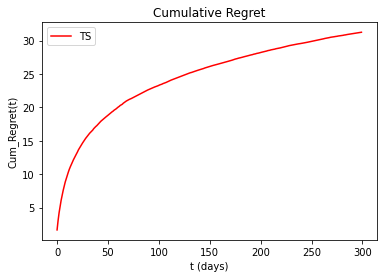

In [15]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

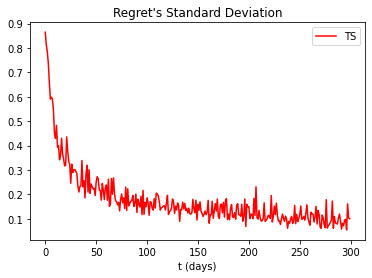

In [16]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

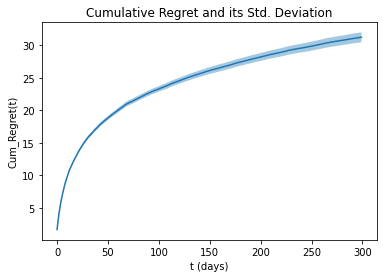

In [17]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

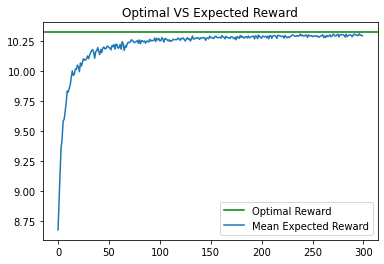

In [18]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 2
daily_users = 200
n_days = 300

In [ ]:
step4_ucb1_R = []
step4_ucb1_collected_rewards = []
opt_reward = env.optimal_reward()[0]
for _ in range(n_runs):
    ucb4 = step4_ucb1(daily_users, len(prices), len(prices[0]), prices, env)
    instant_regret = []
    step4_ucb1_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb4.pull_arms()
        day_data = env.simulate_day(daily_users, pulled_arms, ["conversion_rates", "alpha_ratios", "products_sold"])
        cr_data = day_data["CR_data"]
        alpha_data = day_data["initial_prod"]
        mean_prod_sold = day_data["mean_prod_sold"]
        ucb4.update(pulled_arms, cr_data, alpha_data, mean_prod_sold)
        reward = env.expected_reward(pulled_arms)
        step4_ucb1_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    step4_ucb1_collected_rewards.append(step4_ucb1_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    step4_ucb1_R.append(cumulative_regret)

In [ ]:
# store the result
with open("step4_ucb1_R", 'wb') as f1:
    pickle.dump(step4_ucb1_R, f1)
with open("step4_ucb1_collected_rewards", 'wb') as f1:
    pickle.dump(step4_ucb1_collected_rewards, f1)

In [24]:
# load the result
with open("step4_ucb1_R", 'rb') as f1:
    step4_ucb1_R = pickle.load(f1)
with open("step4_ucb1_collected_rewards", 'rb') as f1:
    step4_ucb1_collected_rewards = pickle.load(f1)

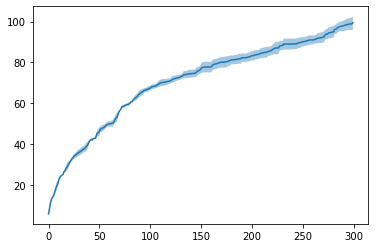

In [25]:
# plot of the result
mean_step4_ucb1_R = np.mean(step4_ucb1_R, axis=0)
std_dev_step4_ucb1 = np.std(step4_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step4_ucb1_R)
plt.fill_between(range(n_days), mean_step4_ucb1_R-std_dev_step4_ucb1, mean_step4_ucb1_R+std_dev_step4_ucb1, alpha=0.4)

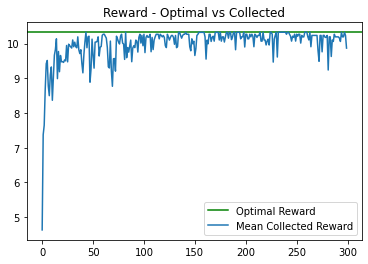

In [26]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step4_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb4.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb4.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(50):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

# STEP 5 : Uncertain conversion rates and graph weights

## - TS

## - UCB1

In [17]:
# setting the run parameters
n_runs = 2
daily_users = 200
n_days = 300

In [18]:
step5_ucb1_R = []
step5_ucb1_collected_rewards = []
opt_reward = env.optimal_reward()[0]
for _ in range(n_runs):
    ucb5 = step5_ucb1(daily_users, len(prices), len(prices[0]), prices, env)
    instant_regret = []
    step5_ucb1_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb5.pull_arms()
        day_data = env.simulate_day(daily_users, pulled_arms, ["conversion_rates", "graph_weights"])
        cr_data = day_data["CR_data"]
        visualizations = day_data["visualizations"]
        clicks = day_data["clicks"]
        ucb5.update(pulled_arms, cr_data, visualizations, clicks)
        reward = env.expected_reward(pulled_arms)
        step5_ucb1_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    step5_ucb1_collected_rewards.append(step5_ucb1_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    step5_ucb1_R.append(cumulative_regret)

In [ ]:
# store the result
with open("step5_ucb1_R", 'wb') as f1:
    pickle.dump(step5_ucb1_R, f1)
with open("step5_ucb1_collected_rewards", 'wb') as f1:
    pickle.dump(step5_ucb1_collected_rewards, f1)

In [ ]:
# load the result
with open("step5_ucb1_R", 'rb') as f1:
    step5_ucb1_R = pickle.load(f1)
with open("step5_ucb1_collected_rewards", 'rb') as f1:
    step5_ucb1_collected_rewards = pickle.load(f1)

In [19]:
ucb5.graph_weights_means

array([[0.        , 0.60059967, 0.13710419, 0.        , 0.        ],
       [0.5031091 , 0.        , 0.28413028, 0.        , 0.        ],
       [0.        , 0.49888737, 0.        , 0.34616293, 0.        ],
       [0.        , 0.        , 0.60569143, 0.        , 0.35738132],
       [0.        , 0.        , 0.3049004 , 0.36015214, 0.        ]])

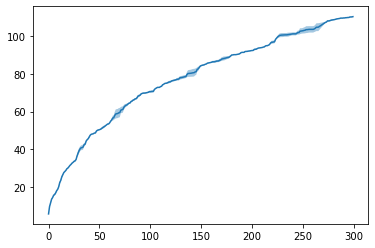

In [20]:
# plot of the result
mean_step5_ucb1_R = np.mean(step5_ucb1_R, axis=0)
std_dev_step5_ucb1 = np.std(step5_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step5_ucb1_R)
plt.fill_between(range(n_days), mean_step5_ucb1_R-std_dev_step5_ucb1, mean_step5_ucb1_R+std_dev_step5_ucb1, alpha=0.4)

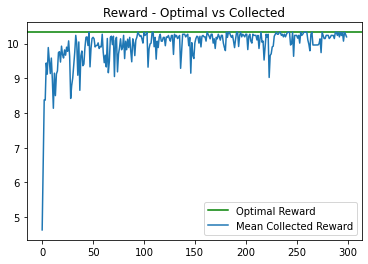

In [21]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step5_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [22]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb5.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

Last n pulled arms:


[[0, 2, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [1, 1, 1, 1, 0],
 [0, 1, 2, 1, 0],
 [0, 2, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [1, 1, 2, 0, 0],
 [0, 1, 2, 1, 0],
 [1, 1, 2, 0, 0]]

In [23]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb5.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(50):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

C:\Users\stefa\AppData\Local\Temp/ipykernel_17184/2204951151.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result.append(x[np.argmax(np.array(x)[:, 1])])
C:\Users\stefa\AppData\Local\Temp/ipykernel_17184/2204951151.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
C:\Users\stefa\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

Optimal arms combination:
[0, 1, 2, 1, 0] 10.325578532573228


Ucb1 most pulled arms:
(arms combination), (n° pulls), (exp rew)


[[[0, 1, 2, 1, 0], 75, 10.325578532573228],
 [[1, 1, 2, 0, 0], 32, 10.211331684267858],
 [[1, 1, 2, 1, 0], 30, 10.211778801621813],
 [[1, 1, 1, 1, 0], 21, 10.060645024657973],
 [[0, 1, 2, 0, 0], 18, 10.322790109653207],
 [[0, 2, 2, 1, 0], 18, 10.14662016402202],
 [[0, 1, 3, 0, 0], 15, 9.815021097468351],
 [[0, 2, 2, 0, 0], 13, 10.142877430469643],
 [[0, 2, 1, 1, 0], 6, 9.986988934645058],
 [[0, 1, 3, 1, 0], 5, 9.827616953215081],
 [[0, 3, 2, 1, 0], 5, 9.504920408374296],
 [[0, 1, 2, 2, 0], 4, 9.928722231644777],
 [[1, 1, 1, 2, 0], 4, 9.66329742227736],
 [[0, 1, 1, 2, 0], 2, 9.765016314040736],
 [[0, 2, 1, 2, 0], 2, 9.594087479886714],
 [[0, 3, 1, 1, 0], 2, 9.317806404610206],
 [[0, 3, 1, 2, 0], 2, 8.94090200446857],
 [[1, 1, 2, 2, 0], 2, 9.81633939742729],
 [[1, 1, 3, 0, 0], 2, 9.708276948422771],
 [[1, 1, 3, 1, 0], 2, 9.719241343747234],
 [[1, 2, 2, 2, 0], 2, 9.6388063570291],
 [[2, 1, 1, 1, 0], 2, 9.285967262651198],
 [[2, 1, 2, 0, 0], 2, 9.440649228397852],
 [[2, 1, 2, 1, 0], 2, 9.4